<a href="https://colab.research.google.com/github/spdkh/Unrolled-optimization-with-deep-priors/blob/master/CIRL_ODPipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SOURCE: https://github.com/Zhengqi-Wu/Unrolled-optimization-with-deep-priors
from scipy.io import loadmat
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import glob

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from PIL import Image

row = 180
col = 180
samples = 800
data1 = np.zeros([samples, row, col, 1], dtype=np.uint8)
data = [[]] * samples
data = [data] * 3
print(data[0])
path = '/content/drive/MyDrive/data/'
folder = '/blurred/'



def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


j = 0
for folder in ['sharp']:#os.listdir(path):
    print(folder)
    i = 0
    for filename in glob.glob(path + folder + '/*.png'):
        if i % (samples // 5) == 0:
            print(i)
        img = rgb2gray(mpimg.imread(filename))
        img = cv2.resize(img, dsize=(row, col))
        
        data[j][i] = (img.reshape(row, col, 1))
        
        i += 1
        if i > samples - 1: 
            break
    j += 1

data = np.array(data)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

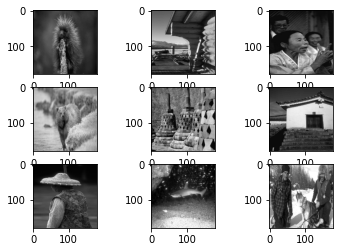

In [ ]:
# Source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Lecture_8.ipynb
# The data, split between train and test sets:
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(data[2][i][:, :, 0], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()


In [ ]:
def plot_beside(imgs, w):
    for i in range(w):
        
        plt.subplot(100 + 10 * (w) + 1 + i)
        plt.imshow(imgs[i], cmap='gray')

    plt.show()

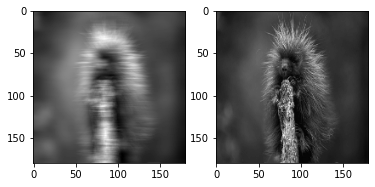

In [ ]:
import cv2

size = 15

# generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

for i in range(samples):
  data[0, i] = cv2.filter2D(data[2, i], -1, kernel_motion_blur).reshape(row,col,1)

plot_beside([data[0, 0,:,:,0], data[2, 0,:,:,0]], 2)
plt.show()

In [ ]:

skip = 2
ratio = 0.75
slc = int(ratio * data[0].shape[0])
x_train = data[0][:slc:skip]
k_train = data[1][:slc:skip]
y_train = data[2][:slc:skip]

x_test = data[0][slc::skip]
k_test = data[1][slc::skip]
y_test = data[2][slc::skip]

# x_train = x_train.astype('float32') / 255.
# y_train = y_train.astype('float32') / 255.
# y_train2 = y_train - x_train + 0.5
# x_test = x_test.astype('float32') / 255.
# y_test = y_test.astype('float32') / 255.
# y_test2 = y_test - x_test + 0.5
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(300, 180, 180, 1) (300, 180, 180, 1) (100, 180, 180, 1) (100, 180, 180, 1)


In [ ]:
print(k_train.shape, k_test.shape)

(300, 180, 180, 1) (100, 180, 180, 1)


In [ ]:
k = kernel_motion_blur
kT = tf.Variable(k.transpose())
#kT = tf.cast(kT, dtype=tf.float32)
k = tf.Variable(k)
k = tf.cast(k, dtype=tf.complex64)
K = tf.signal.fft2d(k) 
Ki = np.linalg.pinv(K)
Ki = np.float32(Ki)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
layer1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer10 = layers.Conv2D(1, (3, 3), activation='relu', padding='same')

# define iterations and learning rate of ODP
#define iterations and learning rate of ODP
A = tf.ones([row, col, 1], tf.float32)
A = tf.multiply(A, -0.5)
it = 2 # number of iterations
alpha = 0.01

#define layers of CNN
#weights = tf.get_variable(name='weights', shape=[5, 5, 3, 16], dtype=tf.float32)
input_img = layers.Input(shape=(row, col, 1)) 
y = input_img

x = input_img
for i in range(it):
  #if i == 0:
    #x = input_img
  #else:
    #x = output
  x_shortcut = x # save for residual process
  x = layer1(x)
  x = layer2(x) 
  x = layer3(x) 
  x = layer4(x) 
  x = layer5(x) 
  x = layer6(x) 
  x = layer7(x) 
  x = layer8(x) 
  x = layer9(x) 
  x = layer10(x)
  x = tf.add(x_shortcut, x)
  x = tf.add(A, x) # reduce x by 0.5. Otherwise x in previous step would be negative.
  ya = tf.multiply(y, alpha)
  ya = tf.multiply(y, alpha)
  x = tf.add(x, ya)
  x = tf.multiply(x, 1/(1+alpha))
  alpha = alpha/2

output = x

ODP = models.Model(input_img, output)
ODP.compile(optimizer=Adam(learning_rate=0.001),
            loss='mean_squared_error',
            metrics = ['accuracy'])
print(ODP.summary())
print(np.shape(output), x_train.shape, y_test.shape)

history = ODP.fit(x_train, y_train,
        epochs=1000,
        batch_size=20,
        shuffle=True,
        validation_data=(x_test, y_test),
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

# 20 epoch 2 it resnet
y_pred = ODP.predict(x_test, batch_size=20)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 180, 64  640         ['input_1[0][0]',                
                                )                                 'tf.math.multiply_1[0][0]']     
                                                                                                  
 conv2d_1 (Conv2D)              (None, 180, 180, 64  36928       ['conv2d[0][0]',                 
                                )                                 'conv2d[1][0]']             

In [ ]:
plot_beside([y_pred[0, :, :, 0], x_test[0, :, :, 0], y_test[0, :, :, 0]], 3)

NameError: ignored

In [ ]:
plt.imshow(y_pred[1,:,:,0], cmap='gray')

In [ ]:
plt.imshow(y_pred[2,:,:,0], cmap='gray')

In [ ]:
plt.imshow(y_pred[3,:,:,0], cmap='gray')

In [ ]:
plt.imshow(y_pred[4,:,:,0], cmap='gray')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()